In [ ]:
pip install catboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 


pd.set_option('display.max_columns', 100)

In [ ]:
data = pd.read_csv('dataset.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Eksplorasi data

Pemeriksaan data yang hilang

In [ ]:
total = data.isnull().sum().sort_values(ascending = False)
pd.concat([total], axis=1, keys=['Data yang hilang']).transpose()

,ID,BILL_AMT2,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1,BILL_AMT6,BILL_AMT5,BILL_AMT4,BILL_AMT3,BILL_AMT1,LIMIT_BAL,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0,AGE,MARRIAGE,EDUCATION,SEX,default.payment.next.month
Data yang hilang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Korelasi antar data

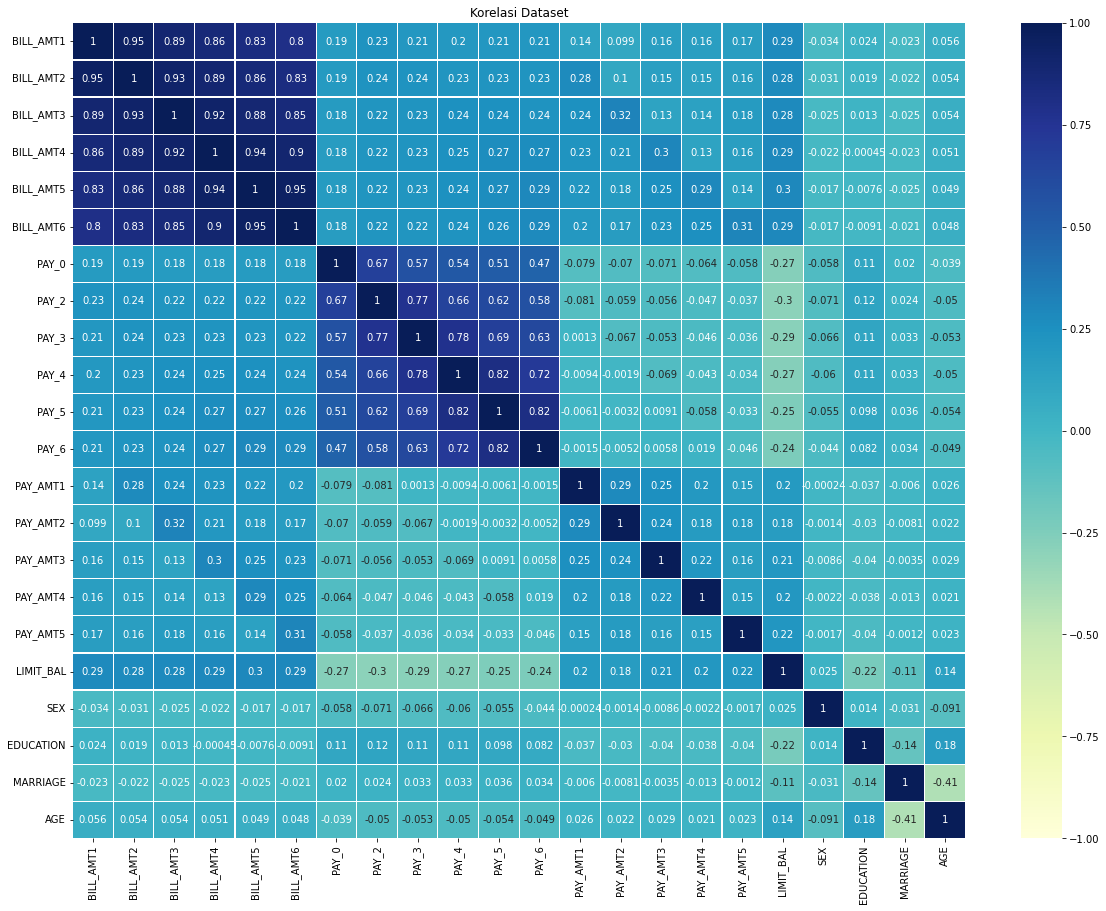

In [ ]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

plt.figure(figsize = (20,15))
plt.title('Korelasi Dataset')
corr = data[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1, annot=True, cmap="YlGnBu")
plt.show()

In [ ]:
target = 'default.payment.next.month'
predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [ ]:
train_df, val_df = train_test_split(data, test_size=0.20, random_state=42)

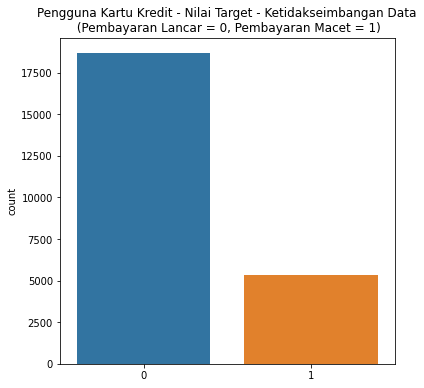

In [ ]:
plt.figure(figsize = (6,6))
plt.title('Pengguna Kartu Kredit - Nilai Target - Ketidakseimbangan Data\n (Pembayaran Lancar = 0, Pembayaran Macet = 1)')
sns.set_color_codes("pastel")
sns.countplot(x=train_df[target].values, data=data)
locs, labels = plt.xticks()
plt.show()

Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=4, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)
rf.fit(train_df[predictors], train_df[target].values)
rf_preds = rf.predict(val_df[predictors])

accuracy=accuracy_score(val_df[target].values, rf_preds)
precision=precision_score(val_df[target].values, rf_preds)
recall =recall_score(val_df[target].values, rf_preds)
f1=f1_score(val_df[target].values, rf_preds)
auc = roc_auc_score(val_df[target].values, rf.predict_proba(val_df[predictors].values)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 81.60%
Precision: 63.80%
Recall: 36.79%
F1 Score: 46.67%
Nilai AUC : 0.76


Artificial Neural Network

In [ ]:
ann = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(5, 2), random_state=42)

ann.fit(train_df[predictors], train_df[target].values)
ann_preds = ann.predict(val_df[predictors])

accuracy=accuracy_score(val_df[target], ann_preds)
precision=precision_score(val_df[target], ann_preds)
recall =recall_score(val_df[target], ann_preds)
f1=f1_score(val_df[target], ann_preds)
auc = roc_auc_score(val_df[target], ann.predict_proba(val_df[predictors])[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("ROC AUC : %.2f" % (auc))

Accuracy: 46.40%
Precision: 18.00%
Recall: 40.75%
F1 Score: 24.97%
ROC AUC : 0.44


Extream Gradien Boosting (XGBoost)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',eta=0.039,
                           max_depth=2,subsample=0.8,
                           colsample_bytree=0.9, eval_metric='auc',
                           random_state=42)

xgb.fit(train_df[predictors], train_df[target].values)
xgb_preds = xgb.predict(val_df[predictors])

accuracy=accuracy_score(val_df[target], xgb_preds)
precision=precision_score(val_df[target], xgb_preds)
recall =recall_score(val_df[target], xgb_preds)
f1=f1_score(val_df[target], xgb_preds)
auc = roc_auc_score(val_df[target], xgb.predict_proba(val_df[predictors])[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 82.07%
Precision: 67.45%
Recall: 34.88%
F1 Score: 45.98%
Nilai AUC : 0.78


Light Gradien Boosting Machine (LGBM)

In [ ]:
m3_lgb = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=100, random_state=42,
                            learning_rate=0.05, max_depth=4, verbose=0)

m3_lgb.fit(train_df[predictors], train_df[target].values)
lgb_preds = m3_lgb.predict(val_df[predictors])

accuracy=accuracy_score(val_df[target], lgb_preds)
precision=precision_score(val_df[target], lgb_preds)
recall =recall_score(val_df[target], lgb_preds)
f1=f1_score(val_df[target], lgb_preds)
auc = roc_auc_score(val_df[target], m3_lgb.predict_proba(val_df[predictors])[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 82.15%
Precision: 67.74%
Recall: 35.19%
F1 Score: 46.32%
Nilai AUC : 0.78


Adaptive Boosting (AdaBoost)

In [ ]:
abc = AdaBoostClassifier(random_state=42,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=100)

abc.fit(train_df[predictors], train_df[target].values)
abc_preds = abc.predict(val_df[predictors])

accuracy=accuracy_score(val_df[target], abc_preds)
precision=precision_score(val_df[target], abc_preds)
recall =recall_score(val_df[target], abc_preds)
f1=f1_score(val_df[target], abc_preds)
auc = roc_auc_score(val_df[target], abc.predict_proba(val_df[predictors])[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 81.60%
Precision: 66.94%
Recall: 31.45%
F1 Score: 42.80%
Nilai AUC : 0.78


Catboost

In [ ]:
cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             metric_period = 50)
cbc.fit(train_df[predictors], train_df[target].values)
cbc_preds = cbc.predict(val_df[predictors])

accuracy=accuracy_score(val_df[target], cbc_preds)
precision=precision_score(val_df[target], cbc_preds)
recall =recall_score(val_df[target], cbc_preds)
f1=f1_score(val_df[target], cbc_preds)
auc = roc_auc_score(val_df[target], cbc.predict_proba(val_df[predictors])[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

0:	total: 241ms	remaining: 2m
50:	total: 8.9s	remaining: 1m 18s
100:	total: 18s	remaining: 1m 11s
150:	total: 27.3s	remaining: 1m 3s
200:	total: 37.3s	remaining: 55.4s
250:	total: 46.5s	remaining: 46.1s
300:	total: 56.6s	remaining: 37.4s
350:	total: 1m 5s	remaining: 28s
400:	total: 1m 15s	remaining: 18.6s
450:	total: 1m 24s	remaining: 9.18s
499:	total: 1m 33s	remaining: 0us
Accuracy: 81.87%
Precision: 65.52%
Recall: 36.18%
F1 Score: 46.61%
Nilai AUC : 0.78


SMOTE

In [ ]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(train_df[predictors], train_df[target].values)

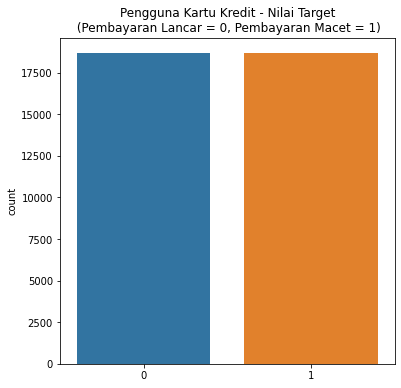

In [ ]:
plt.figure(figsize = (6,6))
plt.title('Pengguna Kartu Kredit - Nilai Target\n (Pembayaran Lancar = 0, Pembayaran Macet = 1)')
sns.set_color_codes("pastel")
sns.countplot(x=y_sm, data=data)
locs, labels = plt.xticks()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.20, random_state=42)

Random Forest + SMOTE

In [ ]:
rf = RandomForestClassifier(n_jobs=4, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

accuracy=accuracy_score(y_test, rf_preds)
precision=precision_score(y_test, rf_preds)
recall =recall_score(y_test, rf_preds)
f1=f1_score(y_test, rf_preds)
auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 84.34%
Precision: 85.88%
Recall: 82.30%
F1 Score: 84.05%
Nilai AUC : 0.92


ANN + SMOTE

In [ ]:
ann = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(5, 2), random_state=42)

ann.fit(X_train, y_train)
ann_preds = ann.predict(X_test)

accuracy=accuracy_score(y_test, ann_preds)
precision=precision_score(y_test, ann_preds)
recall =recall_score(y_test, ann_preds)
f1=f1_score(y_test, ann_preds)
auc = roc_auc_score(y_test, ann.predict_proba(X_test)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("ROC AUC : %.2f" % (auc))

Accuracy: 43.66%
Precision: 43.31%
Recall: 39.99%
F1 Score: 41.58%
ROC AUC : 0.44


XGBoost + SMOTE

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',eta=0.039,
                           max_depth=2,subsample=0.8,
                           colsample_bytree=0.9, eval_metric='auc',
                           random_state=42)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

accuracy=accuracy_score(y_test, xgb_preds)
precision=precision_score(y_test, xgb_preds)
recall =recall_score(y_test, xgb_preds)
f1=f1_score(y_test, xgb_preds)
auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 76.88%
Precision: 78.79%
Recall: 73.76%
F1 Score: 76.19%
Nilai AUC : 0.84


LightGBM Classifier + SMOTE

In [ ]:
m3_lgb = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=100, random_state=42,
                            learning_rate=0.05, max_depth=4, verbose=0)

m3_lgb.fit(X_train, y_train)
lgb_preds = m3_lgb.predict(X_test)

accuracy=accuracy_score(y_test, lgb_preds)
precision=precision_score(y_test, lgb_preds)
recall =recall_score(y_test, lgb_preds)
f1=f1_score(y_test, lgb_preds)
auc = roc_auc_score(y_test, m3_lgb.predict_proba(X_test)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 78.24%
Precision: 80.74%
Recall: 74.32%
F1 Score: 77.40%
Nilai AUC : 0.86


ADABOOST CLASSIFIER + SMOTE

In [ ]:
abc = AdaBoostClassifier(random_state=42,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=100)

abc.fit(X_train, y_train)
abc_preds = abc.predict(X_test)

accuracy=accuracy_score(y_test, abc_preds)
precision=precision_score(y_test, abc_preds)
recall =recall_score(y_test, abc_preds)
f1=f1_score(y_test, abc_preds)
auc = roc_auc_score(y_test, abc.predict_proba(X_test)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 76.11%
Precision: 77.97%
Recall: 72.96%
F1 Score: 75.38%
Nilai AUC : 0.84


CatBoost Classifier + SMOTE

In [ ]:
cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             metric_period = 50)
cbc.fit(X_train, y_train)
cbc_preds = cbc.predict(X_test)

accuracy=accuracy_score(y_test, cbc_preds)
precision=precision_score(y_test, cbc_preds)
recall =recall_score(y_test, cbc_preds)
f1=f1_score(y_test, cbc_preds)
auc = roc_auc_score(y_test, cbc.predict_proba(X_test)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

0:	total: 200ms	remaining: 1m 39s
50:	total: 10.2s	remaining: 1m 29s
100:	total: 19.8s	remaining: 1m 18s
150:	total: 29.5s	remaining: 1m 8s
200:	total: 39.1s	remaining: 58.1s
250:	total: 48.6s	remaining: 48.3s
300:	total: 58.2s	remaining: 38.5s
350:	total: 1m 7s	remaining: 28.9s
400:	total: 1m 17s	remaining: 19.2s
450:	total: 1m 27s	remaining: 9.47s
499:	total: 1m 36s	remaining: 0us
Accuracy: 82.68%
Precision: 84.65%
Recall: 79.95%
F1 Score: 82.24%
Nilai AUC : 0.90


ROUS

In [37]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1.0)

X_over, y_over = over.fit_resample(train_df[predictors], train_df[target].values)
x_rous, y_rous = under.fit_resample(X_over, y_over)


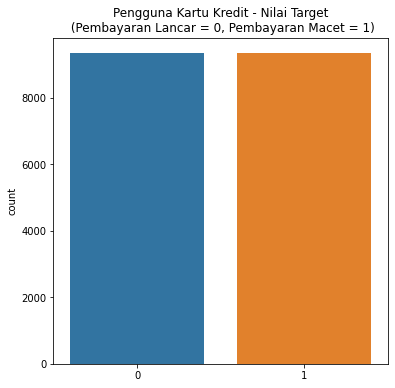

In [38]:
plt.figure(figsize = (6,6))
plt.title('Pengguna Kartu Kredit - Nilai Target\n (Pembayaran Lancar = 0, Pembayaran Macet = 1)')
sns.set_color_codes("pastel")
sns.countplot(x=y_rous, data=data)
locs, labels = plt.xticks()
plt.show()

In [39]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    x_rous, y_rous, test_size=0.20, random_state=42)

Random Forest + ROUS

In [40]:
rf = RandomForestClassifier(n_jobs=4, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)
rf.fit(X_train1, y_train1)
rf_preds = rf.predict(X_test1)

accuracy=accuracy_score(y_test1, rf_preds)
precision=precision_score(y_test1, rf_preds)
recall =recall_score(y_test1, rf_preds)
f1=f1_score(y_test1, rf_preds)
auc = roc_auc_score(y_test1, rf.predict_proba(X_test1)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 83.27%
Precision: 83.15%
Recall: 83.28%
F1 Score: 83.21%
Nilai AUC : 0.90


ANN + ROUS

In [41]:
ann = MLPClassifier(solver='lbfgs',
                    hidden_layer_sizes=(5, 2), random_state=42)

ann.fit(X_train1, y_train1)
ann_preds = ann.predict(X_test1)

accuracy=accuracy_score(y_test1, ann_preds)
precision=precision_score(y_test1, ann_preds)
recall =recall_score(y_test1, ann_preds)
f1=f1_score(y_test1, ann_preds)
auc = roc_auc_score(y_test1, ann.predict_proba(X_test1)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("ROC AUC : %.2f" % (auc))

Accuracy: 43.98%
Precision: 43.10%
Recall: 39.14%
F1 Score: 41.03%
ROC AUC : 0.44


XGBoost + ROUS

In [42]:
xgb = XGBClassifier(objective='binary:logistic',eta=0.039,
                           max_depth=2,subsample=0.8,
                           colsample_bytree=0.9, eval_metric='auc',
                           random_state=42)

xgb.fit(X_train1, y_train1)
xgb_preds = xgb.predict(X_test1)

accuracy=accuracy_score(y_test1, xgb_preds)
precision=precision_score(y_test1, xgb_preds)
recall =recall_score(y_test1, xgb_preds)
f1=f1_score(y_test1, xgb_preds)
auc = roc_auc_score(y_test1, xgb.predict_proba(X_test1)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 71.63%
Precision: 75.38%
Recall: 63.87%
F1 Score: 69.15%
Nilai AUC : 0.79


LightGBM + ROUS

In [43]:
m3_lgb = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=100, random_state=42,
                            learning_rate=0.05, max_depth=4, verbose=0)

m3_lgb.fit(X_train1, y_train1)
lgb_preds = m3_lgb.predict(X_test1)

accuracy=accuracy_score(y_test1, lgb_preds)
precision=precision_score(y_test1, lgb_preds)
recall =recall_score(y_test1, lgb_preds)
f1=f1_score(y_test1, lgb_preds)
auc = roc_auc_score(y_test1, m3_lgb.predict_proba(X_test1)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 71.84%
Precision: 75.00%
Recall: 65.16%
F1 Score: 69.74%
Nilai AUC : 0.79


Adaboost + ROUS

In [44]:
abc = AdaBoostClassifier(random_state=42,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=100)

abc.fit(X_train1, y_train1)
abc_preds = abc.predict(X_test1)

accuracy=accuracy_score(y_test1, abc_preds)
precision=precision_score(y_test1, abc_preds)
recall =recall_score(y_test1, abc_preds)
f1=f1_score(y_test1, abc_preds)
auc = roc_auc_score(y_test1, abc.predict_proba(X_test1)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

Accuracy: 71.36%
Precision: 75.13%
Recall: 63.49%
F1 Score: 68.82%
Nilai AUC : 0.78


Catboost + ROUS

In [45]:
cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             metric_period = 50)
cbc.fit(X_train1, y_train1)
cbc_preds = cbc.predict(X_test1)

accuracy=accuracy_score(y_test1, cbc_preds)
precision=precision_score(y_test1, cbc_preds)
recall =recall_score(y_test1, cbc_preds)
f1=f1_score(y_test1, cbc_preds)
auc = roc_auc_score(y_test1, cbc.predict_proba(X_test1)[:,1], average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Nilai AUC : %.2f" % (auc))

0:	total: 186ms	remaining: 1m 32s
50:	total: 11.1s	remaining: 1m 37s
100:	total: 19.9s	remaining: 1m 18s
150:	total: 28.5s	remaining: 1m 5s
200:	total: 43.2s	remaining: 1m 4s
250:	total: 56.4s	remaining: 55.9s
300:	total: 1m 5s	remaining: 43.4s
350:	total: 1m 21s	remaining: 34.5s
400:	total: 1m 32s	remaining: 22.8s
450:	total: 1m 43s	remaining: 11.2s
499:	total: 1m 57s	remaining: 0us
Accuracy: 79.34%
Precision: 79.82%
Recall: 78.28%
F1 Score: 79.04%
Nilai AUC : 0.87
